In [0]:
from PIL import Image
import numpy as np
import torch
import cv2
import os
import matplotlib.pyplot as plt

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import numpy as np
torch.set_printoptions(linewidth=120)
import cv2
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
torch.set_printoptions(linewidth=120)
from shutil import copy
plt.ion()   # interactive mode

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score

In [0]:
os.chdir('/content/drive/My Drive/mini/notebooks')

In [0]:
df = pd.DataFrame()
images = sorted(os.listdir('/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/images_ead2020'))
masks = sorted(os.listdir('/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/masks_ead2020'))
df['images'] = images
df['masks'] = masks

In [5]:
df = df.sample(frac=1)
len(df)*0.75

355.5

In [0]:
train = df[:350]
test = df[350:]

In [0]:
train.to_csv('/content/drive/My Drive/mini/csv/train.csv', index=False)
test.to_csv('/content/drive/My Drive/mini/csv/test.csv', index=False)

In [0]:
train = pd.read_csv('../csv/train.csv')
test = pd.read_csv('../csv/test.csv')

In [0]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = torch.sigmoid(logits)
        return logits

In [0]:
in_trans = transforms.Compose([
                                 transforms.Resize((225,225),interpolation=2),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

out_trans = transforms.Compose([
                                transforms.Resize((225,225),interpolation=2),
                                transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485],std=[0.229])
])
class EndoData(Dataset):
    def __init__(self,in_dir,out_dir, df):
        self.in_dir = in_dir
        self.out_dir = out_dir
        self.in_list = df['images']
        self.out_list = df['masks']
        
    def __len__(self):
        return len(self.in_list)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        in_name = self.in_dir+self.in_list[idx]
        in_image = Image.open(in_name)
        in_image = in_trans(in_image)

        out_name = self.out_dir+self.out_list[idx]
        out_image = cv2.imread(out_name)
        img = (out_image[:,:,0]+out_image[:,:,1]+out_image[:,:,2])
        ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
        out_image = Image.fromarray(thresh1)
        # print(out_image.size)
        out_image = out_trans(out_image)
        sample = {'in_image': in_image.cuda(), 
                  'out_image': out_image.cuda()
                  }
        return sample

In [0]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [15]:
train_f1 = []
test_f1 = []
traindataset = EndoData('/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/images_ead2020/',
                        '/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/masks_ead2020/', train)
testdataset = EndoData('/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/images_ead2020/', 
                       '/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/masks_ead2020/', test)
fcn = UNet(3,1).cuda()
# fcn = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=1).cuda()
# fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=1).cuda()
batch_size = 1
train_loader = torch.utils.data.DataLoader(traindataset,batch_size)
test_loader = torch.utils.data.DataLoader(testdataset,1)

optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

epoch = 0
no_of_epoch = 500
for epoch in range(no_of_epoch):
    total_loss = 0
    dice_metric = 0
    for batch in train_loader:
        input_imgs,output_imgs = batch['in_image'],batch['out_image']
#         print(input_imgs.shape)
        preds = fcn(input_imgs.float())
        y = output_imgs
        y_pred = preds
        dice_metric += dice_coef(y_pred, y.float()).detach().cpu().numpy().tolist()
        loss = soft_dice_loss(y_pred, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        # print('*',end='')
    torch.save(fcn,'../models/deeplab/'+str(epoch)+'.pt')
    print("epoch:",epoch,"total_loss:",total_loss, "dics coeff:", dice_metric/350/batch_size)
    train_f1.append(dice_metric/10)
    print("----------------------------")
    
    total_loss = 0
    dice_metric = 0
    for batch in test_loader:
        input_imgs,output_imgs = batch['in_image'],batch['out_image']
        preds = fcn(input_imgs.float())
        y = output_imgs
        y_pred = preds
#         print(dice_coef(y_pred, y.float()).detach().cpu().numpy().tolist())
        dice_metric += dice_coef(y_pred, y.float()).detach().cpu().numpy().tolist()
        loss = soft_dice_loss(y_pred, y.float())
        total_loss+=loss.item()
    print("epoch:",epoch,"total_loss:",total_loss, "dics coeff:", dice_metric/124/1)
    test_f1.append(dice_metric/124)
    print("----------------------------")

epoch: 0 total_loss: 284.49548625946045 dics coeff: 0.18715575388135872
----------------------------
epoch: 0 total_loss: 98.82481253147125 dics coeff: 0.20302570506611384
----------------------------
epoch: 1 total_loss: 275.5742936730385 dics coeff: 0.21264487623484457
----------------------------
epoch: 1 total_loss: 96.7451758980751 dics coeff: 0.21979696799309983
----------------------------
epoch: 2 total_loss: 257.758880674839 dics coeff: 0.26354605590130503
----------------------------
epoch: 2 total_loss: 91.8237915635109 dics coeff: 0.2594855475314445
----------------------------
epoch: 3 total_loss: 244.54886281490326 dics coeff: 0.30128896408907685
----------------------------
epoch: 3 total_loss: 90.94141989946365 dics coeff: 0.2666014522579175
----------------------------
epoch: 4 total_loss: 239.76054590940475 dics coeff: 0.3149698691619103
----------------------------
epoch: 4 total_loss: 86.81930434703827 dics coeff: 0.2998443195207191
----------------------------
epoc

KeyboardInterrupt: ignored

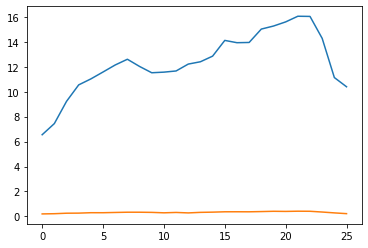

In [17]:
plt.plot(train_f1)
plt.plot(test_f1)

In [0]:
t = [x/35 for x in train_f1]

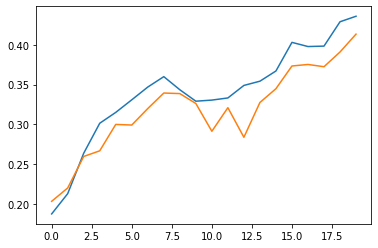

In [24]:
plt.plot(t[:20])
plt.plot(test_f1[:20])